## Uber & Lyft Cab Price Analysis

# Summary 
We started with cleaning the data sets and here are the steps:
1. For the dataset cab_rides, we selected the variables (distance, cab_type, time_stamp, destination, source, price, surge_multiplier, id, product_id and name), converted time_stamp to standard time format, got the hour of the day and deleted all the rows with NAs.
2. For the dataset weather, we selected the variables (temp, location, clouds, pressure, time_stamp, humidity and wind), got the hour of the day ,converted time_stamp to standard time format, and deleted all the rows with NAs. 
3. We combine the two data sets by time and location.

Then we explored the internal and external influence, and made a linear model to predict the price. For the internal influence, we draw the scatter plots and histograms of distance, location,time and carb type; For the external influence, we draw the plots of weather and big events. Finally, we used the model to see how well it fitted our dataset by comparing the predicted values with the actual values. The prediction model shows that distance, ride hour, rains, and surge multiplier have positive influence to the cab price.


# Data Cleaning

- data cleaning cab_rides.csv

In [8]:
%%bq query

create or replace table `ba770b-team4.Team_Dataset.cab_rides` as
SELECT distance, cab_type, time_stamp, destination, source, price, surge_multiplier, id, product_id, name,
format_timestamp("%Y-%m-%d %H:%M:%S", timestamp_millis(time_stamp) ) as ride_time, 
extract(hour from timestamp_millis(time_stamp)) as ride_hour
FROM `ba770b-team4.Team_Dataset.cab_rides`
where distance is not null
and cab_type is not null
and time_stamp is not null
and destination is not null
and source is not null
and price is not null
and surge_multiplier is not null
and id is not null
and product_id is not null;


distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,ride_time,ride_hour
1.43,Lyft,1543612078291,Back Bay,Fenway,7.0,1.0,316f4f8c-f827-4105-863b-93d3f2bacb01,lyft,Lyft,2018-11-30 21:07:58,21
1.57,Lyft,1543882984574,Back Bay,Fenway,7.0,1.0,1dcfa602-ab44-48c6-87e2-efdccb2525d6,lyft,Lyft,2018-12-04 00:23:04,0
1.46,Lyft,1543790282040,Back Bay,Fenway,7.0,1.0,9629b197-ae8b-46ee-b2ca-4d2ddbeb67cf,lyft,Lyft,2018-12-02 22:38:02,22
1.49,Lyft,1543532284999,Back Bay,Fenway,7.0,1.0,f9d6b430-b420-4a78-b368-b1cc707e1b7e,lyft,Lyft,2018-11-29 22:58:04,22
1.48,Lyft,1543263071586,Back Bay,Fenway,13.5,2.0,0dfe4ff4-24c3-4527-ba80-88c947ba6d66,lyft,Lyft,2018-11-26 20:11:11,20
1.48,Lyft,1543756386851,Back Bay,Fenway,7.0,1.0,cc8f13b4-d6a6-4da3-ac24-6cd4cbab73ac,lyft,Lyft,2018-12-02 13:13:06,13
1.44,Lyft,1545005405224,Back Bay,Fenway,7.0,1.0,023c25c3-c0cc-4559-9370-2554c7e3cb49,lyft,Lyft,2018-12-17 00:10:05,0
1.43,Lyft,1543585379420,Back Bay,Fenway,7.0,1.0,9f47e57d-d8d6-4051-a5ce-88656dfe35ea,lyft,Lyft,2018-11-30 13:42:59,13
1.45,Lyft,1544847903386,Back Bay,Fenway,9.0,1.25,7e74da48-30a3-4d61-a390-7c4614c6409a,lyft,Lyft,2018-12-15 04:25:03,4
1.47,Lyft,1544962811294,Back Bay,Fenway,9.0,1.25,d6230586-d1e5-4fd3-b757-ba58e04539c8,lyft,Lyft,2018-12-16 12:20:11,12


- data cleaning weather.csv

In [6]:
%%bq query

create or replace table `ba770b-team4.Team_Dataset.weather` as
select temp, location, clouds, pressure, time_stamp, humidity, wind,
format_timestamp("%Y-%m-%d %H:%M:%S", timestamp_seconds(time_stamp))as weather_time,
extract(hour from timestamp_seconds(time_stamp)) as weather_hour,
case when rain is null then 0
else rain end as rain
from `ba770b-team4.Team_Dataset.weather`
where weather_time is not null;

temp,location,clouds,pressure,time_stamp,humidity,wind,weather_time,weather_hour,rain
41.65,Haymarket Square,0.81,990.63,1543344320,0.76,10.15,2018-11-27 18:45:20,18,0.0
41.42,North Station,0.81,990.53,1543344320,0.75,12.13,2018-11-27 18:45:20,18,0.0
41.31,Boston University,0.81,990.57,1543344320,0.76,12.0,2018-11-27 18:45:20,18,0.0
41.83,Fenway,0.79,990.84,1543346120,0.75,10.42,2018-11-27 19:15:20,19,0.0
41.81,Northeastern University,0.79,990.84,1543346120,0.75,10.41,2018-11-27 19:15:20,19,0.0
41.95,North Station,0.81,991.63,1543347920,0.73,10.87,2018-11-27 19:45:20,19,0.0
43.05,Northeastern University,0.81,990.82,1543347920,0.72,8.31,2018-11-27 19:45:20,19,0.0
43.28,Back Bay,0.81,990.81,1543347920,0.71,8.3,2018-11-27 19:45:20,19,0.0
41.89,West End,0.81,991.64,1543347920,0.74,10.88,2018-11-27 19:45:20,19,0.0
43.43,Financial District,0.71,991.08,1543349720,0.7,8.79,2018-11-27 20:15:20,20,0.0


# Distance vs Price

We use scatter polt to show the relationship between `price` and `distance`. As we see, distance and price have positive relationship, as the distance increases, in most of cases, the price increases.

- Scatter plot of distance & average price

In [10]:
%%bq query -n distance
select distance, avg(price) as avg_price

FROM `ba770b-team4.Team_Dataset.cab_rides`

group by distance
order by distance DESC;

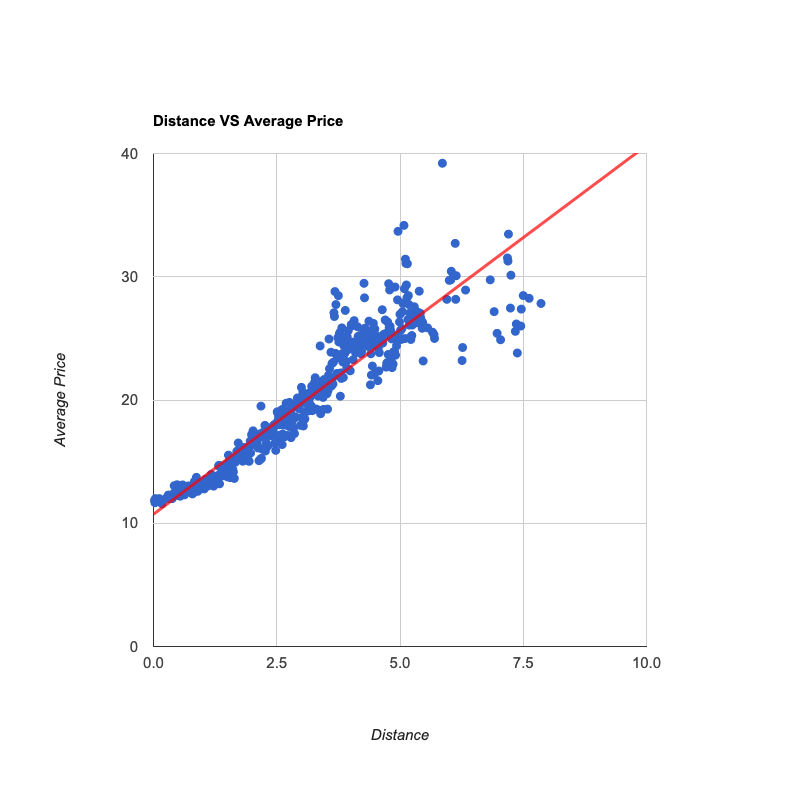

In [14]:
%%chart scatter -d distance
title: Distance VS Average Price
height: 800
width: 800
vAxis: 
  title: Average Price
    
hAxis: 
  title: Distance
legend: none
trendlines: { 0: {
      type: 'linear',
      color: 'red',
      lineWidth: 3,
      opacity: 0.7,
      showR2: true,
      visibleInLegend: true
              }
            }

# Time VS Price

- Top 10 rush hour of cab price

In [9]:
%%bq query
select ride_hour, avg(price) as avg_price
FROM `ba770b-team4.Team_Dataset.cab_rides`

group by ride_hour
order by avg_price DESC
limit 10;

ride_hour,avg_price
17,16.6079964381
21,16.6043230655
8,16.6033263196
20,16.599207961
22,16.5953567342
4,16.5793110048
0,16.5747690145
2,16.5618033659
11,16.5585056895
19,16.5524372294


- Bar chart of rides hours & price

We use bar chart to analysis the relationship between `ride hour` and `average price`. Regardless of what time it is, the average price vibrates around $16.55. The highest average price is $16.608 around 17:00 which is around the rush hour, and the lowest average price is $16.486 around noon.

In [2]:
%%bq query -n hour
select  ride_hour,avg(price) as avg_price

FROM `ba770b-team4.Team_Dataset.cab_rides`

group by ride_hour
order by ride_hour DESC;

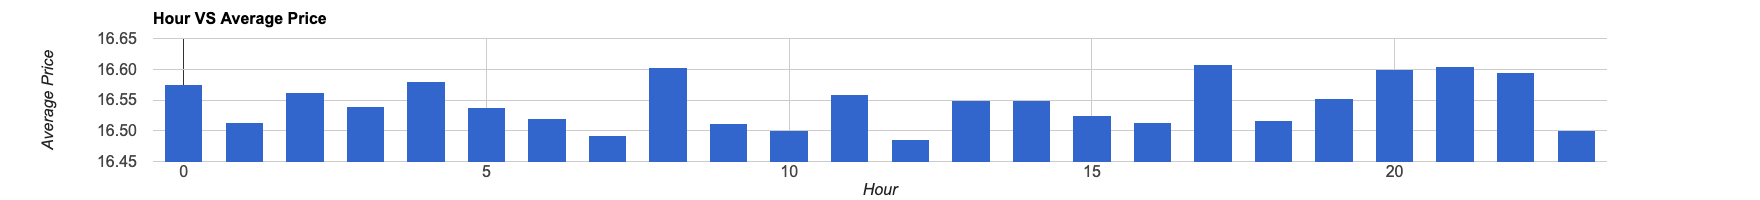

In [3]:
%%chart columns -d hour
title: Hour VS Average Price
hAxis: 
  title: Hour
vAxis: 
  title: Average Price
legend: none

 # Geographic Location VS Average Price

- Source/Destination Navigation

In the beginning, we got the distinct values of `source`(the district that the ride starts) and `destination`(the district that the ride ends) in our cleaned dataset `cab_rides`.

In [14]:
%%bq query
select distinct(destination) 
from `ba770b-team4.Team_Dataset.cab_rides`;

destination
Back Bay
West End
Beacon Hill
North Station
Theatre District
Financial District
Fenway
North End
South Station
Haymarket Square


In [15]:
%%bq query
select distinct(source) 
from `ba770b-team4.Team_Dataset.cab_rides`;

source
Fenway
Back Bay
West End
North End
Beacon Hill
North Station
South Station
Haymarket Square
Theatre District
Boston University


From results, we can see that for both `source` and `destination`, each of them has 12 unique districts, and these 12 districts values are identical for `source` and `destination`. 



- Source vs Avg Price & Destination vs Avg Price

In order to investigate relationships between the start district and the end district, we computed the average prices for each distinct district in `source` and `destination`. 

In [17]:
%%bq query 
select destination, avg(price) as avg_price,count(id) as numberoftrips
from `ba770b-team4.Team_Dataset.cab_rides` 
group by destination
order by avg_price DESC
limit 5;

destination,avg_price,numberoftrips
Boston University,18.9421366911,53171
Fenway,18.1464187639,53166
Financial District,18.0462798937,54192
Northeastern University,17.8275167874,53165
North Station,16.8052380318,52577


In [18]:
%%bq query
select source, avg(price) as avg_price, count(id) as numberoftrips 
from `ba770b-team4.Team_Dataset.cab_rides` 
group by source
order by avg_price DESC
limit 5;

source,avg_price,numberoftrips
Boston University,18.8530335515,53172
Fenway,18.3794906519,53166
Financial District,18.1813716626,54197
Northeastern University,17.9011238808,53164
Theatre District,16.5969944174,53201


- Bar chart of Source vs Avg Price & Destination vs Avg Price

From the bar chart, we can see that for both `source` and `destination`, the district `Boston University` has the highest average price. 

In other words, compared with other starting districts, the rides started from Boston University have the highest average price. 

Also, the rides ends from Boston University have the highest average price compared with other destinations.

Specifically, though by average price, orders in graphs of source vs avg_price and destination vs avg_price are similar to each other, they are not completely identical. For example, as starting district, rides from Beacon Hill has 10th average price. However, as ending district, rides from Beacon Hill has 6th average price, with difference of 4 instead. 

In [21]:
%%bq query -n limits
select source, avg(price) as avg_price from `ba770b-team4.Team_Dataset.cab_rides` 
group by source
order by avg_price DESC;

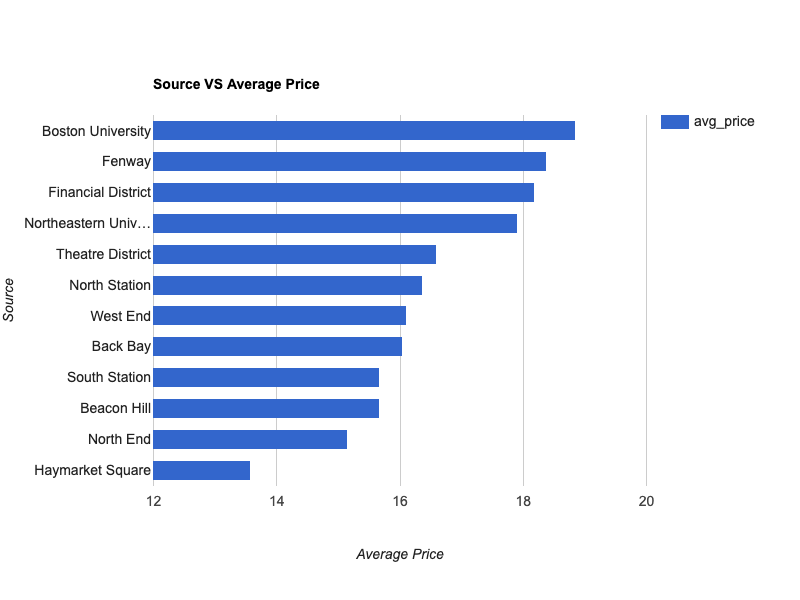

In [22]:
%%chart bars --data limits
title: Source VS Average Price
height: 600
width: 800
hAxis: 
  title: Average Price
vAxis: 
  title: Source
legend: average price

In [24]:
%%bq query -n limitd
select destination, avg(price) as avg_price from `ba770b-team4.Team_Dataset.cab_rides` 
group by destination
order by avg_price DESC;

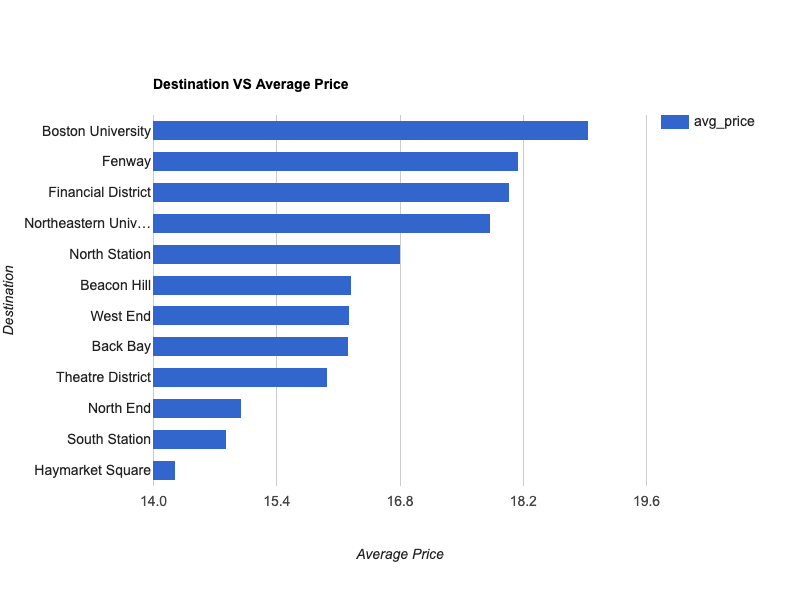

In [25]:
%%chart bars --data limitd
title: Destination VS Average Price
height: 600
width: 800
hAxis: 
  title: Average Price
vAxis: 
  title: Destination
legend: average price

- Connecting distinct routes by source and destination

To get better understanding, we computed 72 distinct routes by concating distinct values of source and destination. 

In [29]:
%%bq query
SELECT 
CONCAT(source, '-', destination) AS trip, 
count(id) as number_of_trips,
avg(price) as avg_price
FROM   `ba770b-team4.Team_Dataset.cab_rides` 
group by trip 
order by avg_price DESC;

trip,number_of_trips,avg_price
Financial District-Boston University,8940,25.4984340045
Boston University-Financial District,8940,24.1460850112
Fenway-Financial District,8916,23.4388178555
Financial District-Fenway,8928,23.4048499104
Northeastern University-Financial District,8874,22.582093757
Financial District-Northeastern University,8868,21.9185836716
Theatre District-Boston University,9173,20.3606617246
Boston University-North Station,8730,20.1853379152
Northeastern University-North Station,8904,19.9109389039
Fenway-North Station,8970,19.7018394649


In [31]:
%%bq query -n trip
SELECT CONCAT(source, '-', destination) AS trip,
       avg(price) avg_price
       FROM   `ba770b-team4.Team_Dataset.cab_rides` 
       group by trip 
order by avg_price DESC;

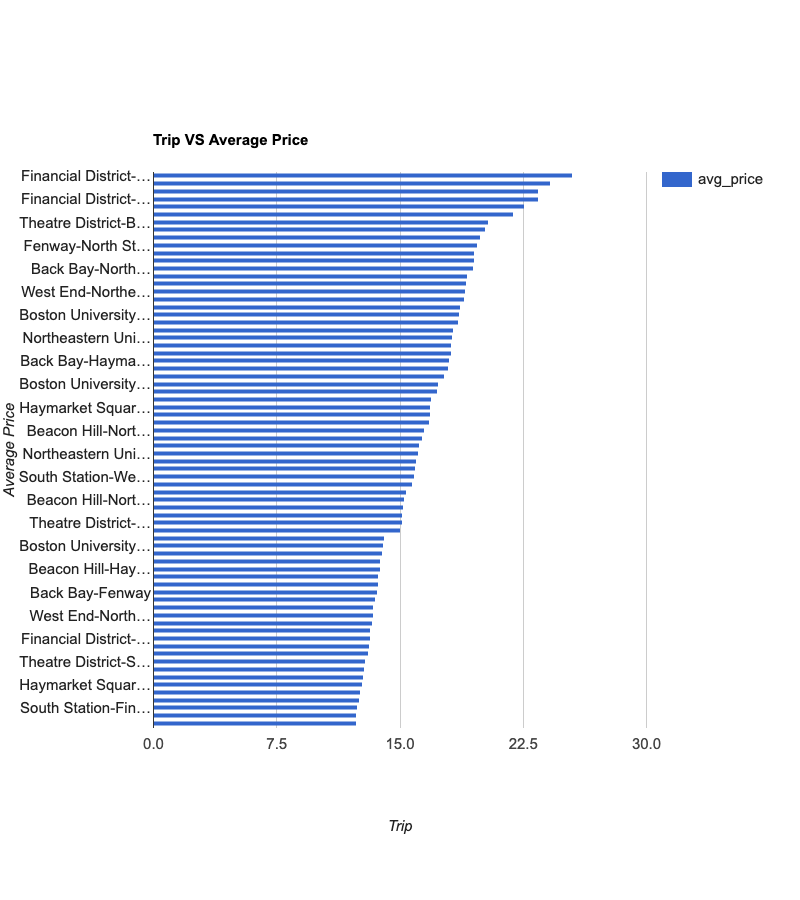

In [32]:
%%chart bars --data trip
title: Trip VS Average Price
height: 900
width: 800
hAxis: 
  title: Trip
vAxis: 
  title: Average Price
legend: average price

According to the aboved table and chart, there are 72 distinct routes in total on the graph. By moving mouse pointer to each individual column, the full name of each route and its average price could be seen.

It is clearly that the route from `Haymarket Square` to `North Station` has the lowest price, while both two places are closed to each other geographically. 
Meanwhile, the route of `Financial District` to `Boston University` is the most expensive route with average price of $25.498, while two places are relatively far compared with most of other routes.  

- Improvement and Other considerations

1. Due to limited tools that could be used, we could not create a map with each route labled geographically. 

2. We tried to combine two trips whose starting station is identical to another trip's end district and vice versa.
   For example:
   route1: source- Back Bay, Destination - Financial Center  
   route2: Source - Financial Center, destination - Back Bay. 
    
   However, if we did that, the graph and data that we got would miss many informations. Even though their source and destination are interchangeable, due to different trip id and other different factors, such as time, weather, etc, we cannot just analyze these two trips as one identical trip. 


# Cab Type VS Price

- Top 10 Cab Type of Price

In [34]:
%%bq query
select name,cab_type,avg(price) as avg_price from `ba770b-team4.Team_Dataset.cab_rides` 
group by name, cab_type
order by avg_price DESC
limit 10;

name,cab_type,avg_price
Lux Black XL,Lyft,32.324086074
Black SUV,Uber,30.2867631044
Lux Black,Lyft,23.0624680394
Black,Uber,20.5237861875
Lux,Lyft,17.771240363
UberXL,Uber,15.6781436039
Lyft XL,Lyft,15.3093627403
UberX,Uber,9.76507423676
WAV,Uber,9.76501923915
Lyft,Lyft,9.61088474676


- Bar chart of Cab Type & Price

It's clear that different cab type would have different price. We use bar chart to analyze the relationship between `cab type` and `price`. According to the plot, Lux Black XL has the highest average price, while shared cab has the lowest.

In [36]:
%%bq query -n cab_type
select name,avg(price) as avg_price from `ba770b-team4.Team_Dataset.cab_rides` 
group by name
order by avg_price DESC;

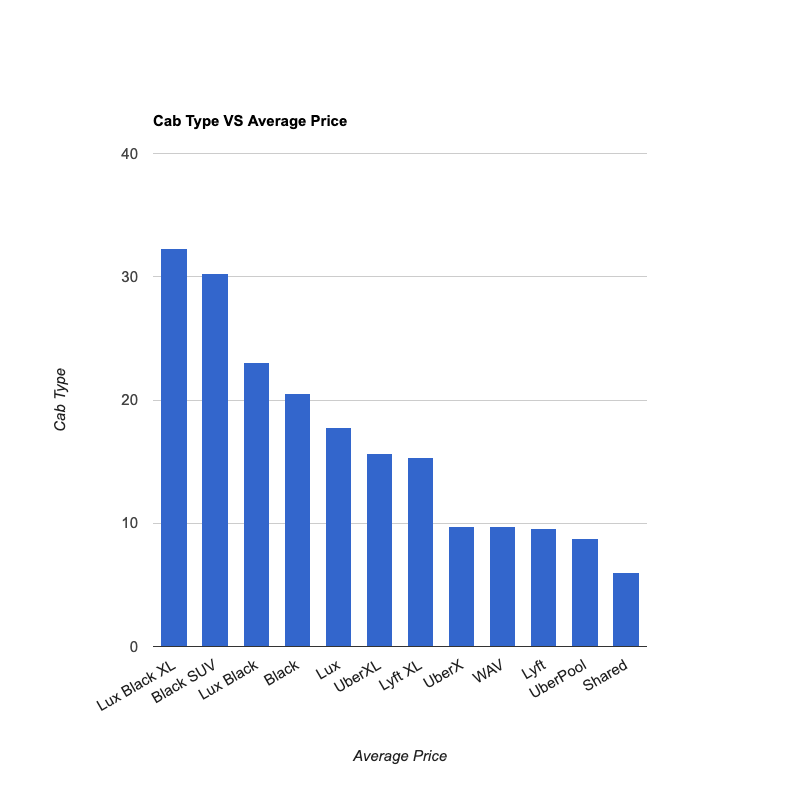

In [37]:
%%chart columns --data cab_type
title: Cab Type VS Average Price
height: 800
width: 800
hAxis: 
  title: Average Price
vAxis: 
  title: Cab Type
legend: none

# Weather VS Price

- `Temperature`

We computed the average price of `(price/distance)` by `temperature`, deleted one extreme value and then drew a scatter plot.

In [43]:
%%bq query -n temperature
select temp, avg_price
from
(
select temp, avg(price/distance) as avg_price
FROM
(SELECT distance, cab_type, c.time_stamp, destination,source, price, surge_multiplier, product_id, name, ride_time, ride_hour, id, temp, location, clouds, pressure, humidity, wind, rain
FROM `ba770b-team4.Team_Dataset.cab_rides` AS c
FULL outer JOIN  `ba770b-team4.Team_Dataset.weather` AS w 
ON ride_time = weather_time AND source = location)
where price is not null and temp is not null 
group by temp
order by avg_price DESC
)
where avg_price < 100;

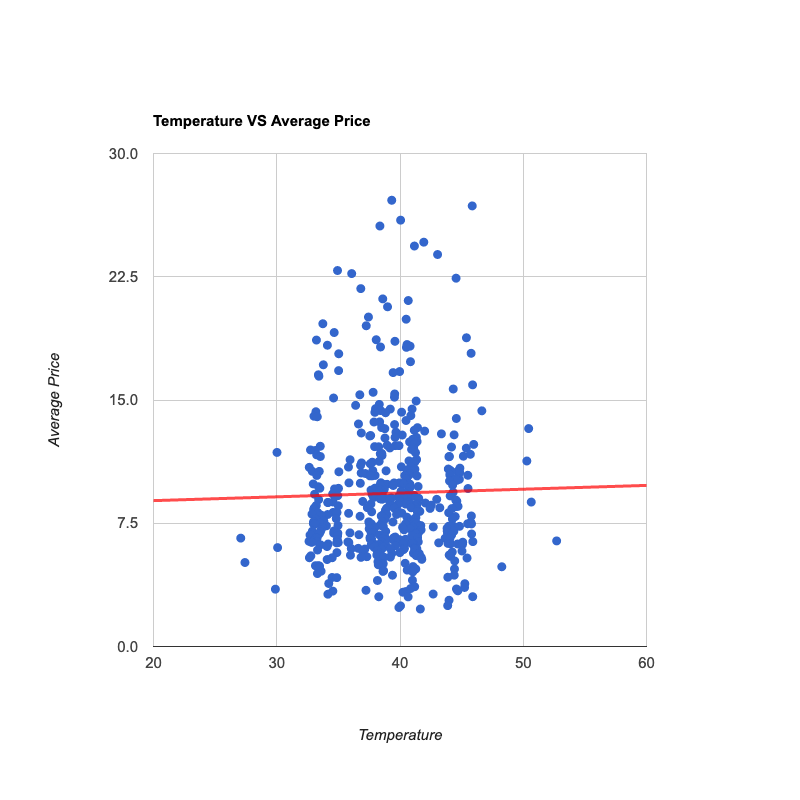

In [45]:
%%chart scatter -d temperature
title: Temperature VS Average Price
height: 800
width: 800
hAxis: 
  title: Temperature  
vAxis: 
  title: Average Price
legend: none
trendlines: { 0: {
      type: 'linear',
      color: 'red',
      lineWidth: 3,
      opacity: 0.7,
      showR2: true,
      visibleInLegend: true
              }
            }

Based on this scatter plot, most data points are distributed mostly at (8,40) and it seems that there is no relationship between the average price and temperature. We also added a trend line to see the relationship but the line seems like very horizontal.

- `Humidity`

We computed the average price of `(price/distance)` by `humidity`, then draw a scatter plot.

In [49]:
%%bq query -n Humidity
select humidity, avg(price/distance) as avg_price
FROM
(SELECT distance, cab_type, c.time_stamp, destination, source, price, surge_multiplier, product_id, name, ride_time, ride_hour, id, temp, location, clouds, pressure, humidity, wind, rain
FROM `ba770b-team4.Team_Dataset.cab_rides` AS c
FULL outer JOIN  `ba770b-team4.Team_Dataset.weather` AS w
ON ride_time = weather_time AND source = location)
    where price is not null 
  and humidity is not null
group by Humidity
order by avg_price DESC;

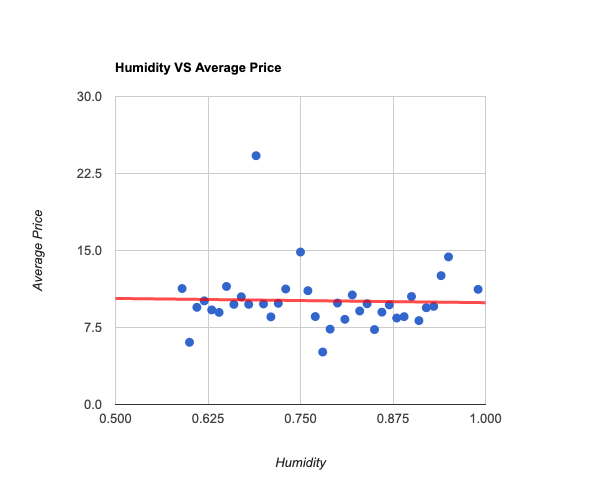

In [51]:
%%chart scatter -d Humidity
title: Humidity VS Average Price
height: 500
width: 600
hAxis: 
  title: Humidity
vAxis: 
  title: Average Price
legend: none
trendlines: { 0: {
      type: 'linear',
      color: 'red',
      lineWidth: 3,
      opacity: 0.7,
      showR2: true,
      visibleInLegend: true
              }
            }

This scatter plot shows most data points are distributed on a horizontal line, thus we conclude there is nonlinear relationship between humidity and average price.

- `Pressure`

We computed the average price of `(price/distance)` by `pressure`, deleted one extreme value and then draw a scatter plot.

In [59]:
%%bq query -n pressure
select pressure, avg_price
from
(
select avg(price/distance) as avg_price,pressure
  FROM
(SELECT distance, cab_type, c.time_stamp, destination,source, price, surge_multiplier, product_id, name, ride_time, ride_hour, id, temp, location, clouds, pressure, humidity, wind, rain
FROM `ba770b-team4.Team_Dataset.cab_rides` AS c
FULL outer JOIN  `ba770b-team4.Team_Dataset.weather` AS w
ON ride_time = weather_time AND source = location)
    where price is not null 
  and pressure is not null
group by pressure
order by avg_price DESC
) 
where avg_price < 100;

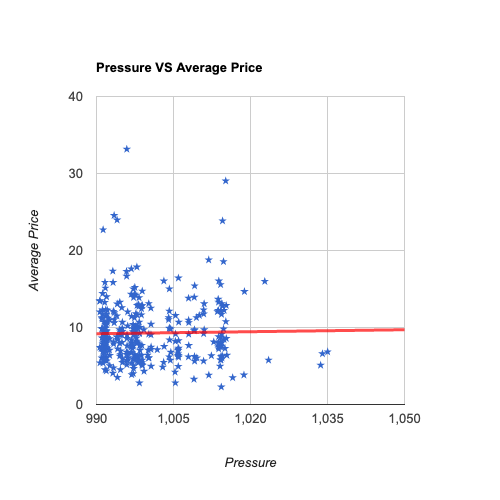

In [60]:
%%chart scatter -d pressure
title: Pressure VS Average Price
height: 500
width: 500
hAxis: 
  title: Pressure
vAxis: 
  title: Average Price
legend: none

pointShape: 'star'
trendlines: { 0: {
      type: 'linear',
      color: 'red',
      lineWidth: 3,
      opacity: 0.7,
      showR2: true,
      visibleInLegend: true
              }
            }

We added a trendline on this scatter plot but it seems like there is no relationship between avergae price and pressure since most data points are distributed in a square so we conclude there is nonlinear relationship between pressure and average price.

- `Wind`

We computed the average price of (`price/distance`) by `wind`, deleted one extreme value and then draw a scatter plot.

In [62]:
%%bq query -n wind
select wind, avg_price
from
(
select avg(price/distance) as avg_price,wind
  FROM
(SELECT distance, cab_type, c.time_stamp, destination,source, price, surge_multiplier, product_id, name, ride_time, ride_hour, id, temp, location, clouds, pressure, humidity, wind, rain
FROM `ba770b-team4.Team_Dataset.cab_rides` AS c
FULL outer JOIN  `ba770b-team4.Team_Dataset.weather` AS w
ON ride_time = weather_time AND source = location)
    where price is not null 
  and wind is not null
group by wind
order by avg_price DESC
)
where avg_price < 100;

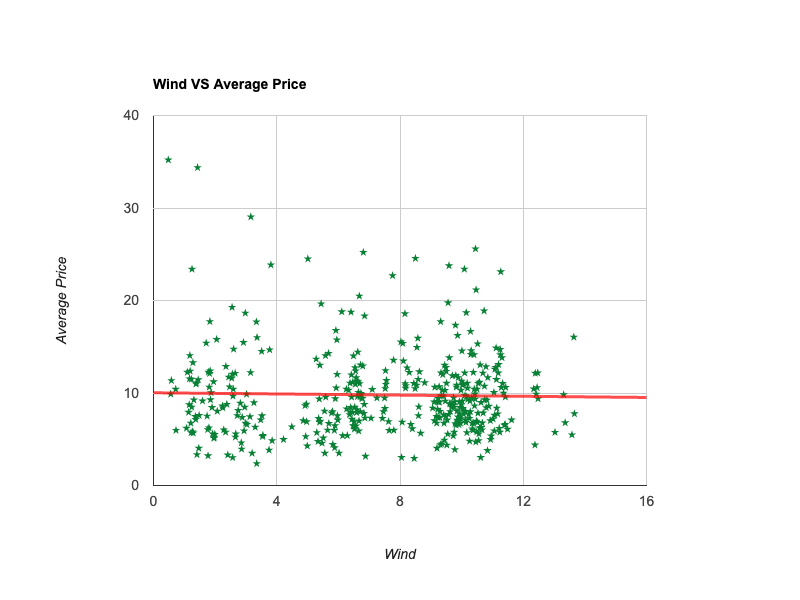

In [64]:
%%chart scatter -d wind
title: Wind VS Average Price
height: 600
width: 800
hAxis: 
  title: Wind
vAxis: 
  title: Average Price
legend: none
colors: ['#088035']
pointShape: 'star'
trendlines: { 0: {
      type: 'linear',
      color: 'red',
      lineWidth: 3,
      opacity: 0.7,
      showR2: true,
      visibleInLegend: true
              }
            }

Based on this scatter plot, it seems there is nonlinear relationship between wind and average price.

- `Rain`

We used the average price of (`price/distance`) and `wind` to draw a scatter plot

In [8]:
%%bq query -n rain
select rain, avg(price/distance) as avg_price
  FROM
(SELECT distance, cab_type, c.time_stamp, destination,source, price, surge_multiplier, product_id, name, ride_time, ride_hour, id, temp, location, clouds, pressure, humidity, wind, rain
FROM `ba770b-team4.Team_Dataset.cab_rides` AS c
FULL outer JOIN  `ba770b-team4.Team_Dataset.weather` AS w
ON ride_time = weather_time AND source = location)
where price is not null 
and wind is not null
and rain <> 0
group by rain
order by avg_price DESC;

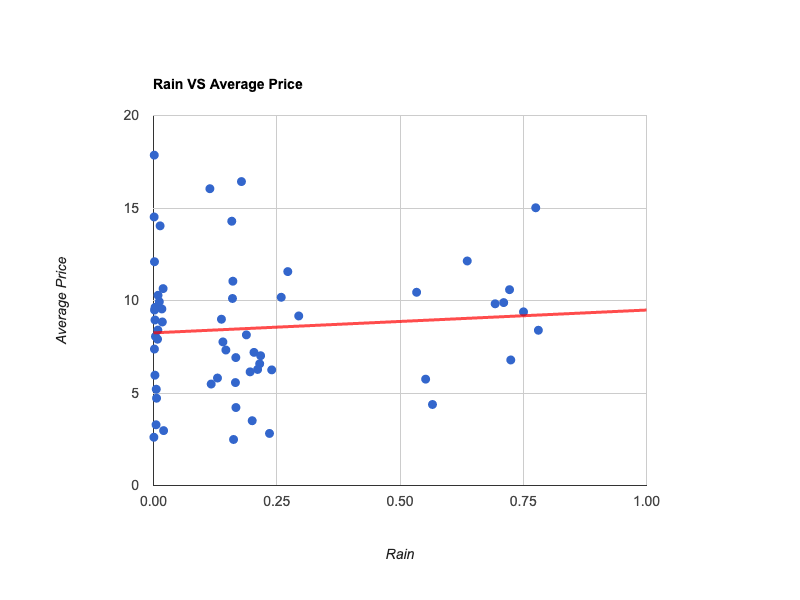

In [9]:
%%chart scatter -d rain
title: Rain VS Average Price
height: 600
width: 800
hAxis: 
  title: Rain
vAxis: 
  title: Average Price
legend: none
trendlines: { 0: {
      type: 'linear',
      color: 'red',
      lineWidth: 3,
      opacity: 0.7,
      showR2: true,
      visibleInLegend: true
              }
            }

Based on this scatter plot, it seems a week positive realtionship between rain and average price. In addition, we added a linear trend line which is y=5.187*(10^-3)x + 0.163.

# Influence of Big Event

When it comes to the big events like sport matches, the cab price would increase sharply. As our rides time data between November and December, we pick Boston Celtics matches as the example to analyse the influence of big events to the cab price.

-  Average Cab Price of Important Game Day

In [87]:
%%bq query
with calendar_game as
(
select 
extract(date from timestamp_millis(time_stamp)) as ride_date,
avg(price) as avg_price
from `ba770b-team4.Team_Dataset.cab_rides` 
inner JOIN `ba770b-team4.Team_Dataset.celtics`
ON date = extract(date from timestamp_millis(time_stamp))
where source = 'South Station'
group by ride_date 
order by avg_price DESC
)
select avg(avg_price) as game_price
from calendar_game;

game_price
15.6575024589


-  Average Cab Price of Normal Day

In [89]:
%%bq query
with calendar_normal as 
(
select 
extract(date from timestamp_millis(time_stamp)) as date,
avg(price) as avg_price
from `ba770b-team4.Team_Dataset.cab_rides` 
where source = 'South Station'
and extract(date from timestamp_millis(time_stamp)) <> '2018-12-10'
and extract(date from timestamp_millis(time_stamp)) <> '2018-12-14'
and extract(date from timestamp_millis(time_stamp)) <> '2018-11-30'
group by date
)
select avg(avg_price) as normal_price
from calendar_normal;

normal_price
15.6301247459


According to the aboved tables, the average price of game days is slightly higher than the average price of normal days.

# Price Prediction

We want to study how other factors may influence the price of cab riding. As mentioned aboved, only `rain` shows the influence to the price in all weather factors, we set up a linear regression model to predict the rides price by using the factors of distance, ride hour, rains, and surge multiplier. We use half of the data to train the model, while the others to evaluate the model.

- Set regression database

Firstly, we join the two table together in order to select data more convenient.

In [90]:
%%bq query
create or replace table `ba770b-team4.Team_Dataset.Join_Data` AS 
(
select distinct id, distance, cab_type, time_stamp, destination,source, price, surge_multiplier, product_id, name, ride_time, ride_hour, temp, location, clouds, pressure, humidity, wind, rain
from
(
SELECT distance, cab_type, c.time_stamp, destination,source, price, surge_multiplier, product_id, name, ride_time, ride_hour, id, temp, location, clouds, pressure, humidity, wind, rain
FROM `ba770b-team4.Team_Dataset.cab_rides` AS c
FULL outer JOIN  `ba770b-team4.Team_Dataset.weather` AS w
ON ride_time = weather_time AND source = location
)
where id is not null
and pressure is not null
);

id,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,product_id,name,ride_time,ride_hour,temp,location,clouds,pressure,humidity,wind,rain
b81d2253-177f-47e9-b0e8-7ad2b01d3b29,5.22,Lyft,1543464558894,Boston University,Financial District,26.0,1.0,lyft_premier,Lux,2018-11-29 04:09:18,4,38.0,Financial District,0.59,998.46,0.7,9.51,0.0
6f1f1cb5-61a8-40fd-aa7e-14e7a5921cf4,5.22,Lyft,1543464558894,Boston University,Financial District,47.5,1.0,lyft_luxsuv,Lux Black XL,2018-11-29 04:09:18,4,38.0,Financial District,0.59,998.46,0.7,9.51,0.0
b44a6b9b-7a90-4765-84a6-9bf8a7d2496a,5.22,Lyft,1543464558894,Boston University,Financial District,22.5,1.0,lyft_plus,Lyft XL,2018-11-29 04:09:18,4,38.0,Financial District,0.59,998.46,0.7,9.51,0.0
053d69b4-fd8e-4dbb-ade0-dc3c40531268,5.22,Lyft,1543464558894,Boston University,Financial District,38.0,1.0,lyft_lux,Lux Black,2018-11-29 04:09:18,4,38.0,Financial District,0.59,998.46,0.7,9.51,0.0
176ce282-1e5b-47f7-b092-5f4b673bf2b7,2.44,Uber,1543451968560,Northeastern University,Financial District,10.5,1.0,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,WAV,2018-11-29 00:39:28,0,38.0,Financial District,0.76,996.81,0.71,11.17,0.0
25ec9fd7-c8c0-4ed7-9b77-2b13dae26437,2.44,Uber,1543451968560,Northeastern University,Financial District,19.5,1.0,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,2018-11-29 00:39:28,0,38.0,Financial District,0.76,996.81,0.71,11.17,0.0
9eec6998-7d32-43e2-a032-6d9f12a2a57a,2.2,Uber,1543468659630,Haymarket Square,Back Bay,9.5,1.0,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,WAV,2018-11-29 05:17:39,5,38.0,Back Bay,0.45,999.26,0.7,10.06,0.0
e78d77fe-9560-4c25-9f20-b4b7a8fbfc0f,1.03,Lyft,1543220463837,North End,Financial District,16.5,1.0,lyft_lux,Lux Black,2018-11-26 08:21:03,8,42.0,Financial District,0.97,1014.42,0.89,1.39,0.0
d498ac35-98a2-415d-8790-c143ed17fe93,1.03,Lyft,1543220463837,North End,Financial District,10.5,1.0,lyft_premier,Lux,2018-11-26 08:21:03,8,42.0,Financial District,0.97,1014.42,0.89,1.39,0.0
17ced235-fefa-4076-bbb4-070ef1920f4e,4.55,Uber,1543457206095,Financial District,Northeastern University,12.5,1.0,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,WAV,2018-11-29 02:06:46,2,38.25,Northeastern University,0.51,997.92,0.71,10.26,0.0


- Create Regression Model of `price`.

In [42]:
%%bq query
create or replace model `ba770b-team4.Team_Dataset.regression_with_distance`
options(
model_type = 'linear_reg',
input_label_cols = ['price']
) as 
select price, distance, ride_hour, rain, surge_multiplier
from `ba770b-team4.Team_Dataset.Join_Data`
where MOD(ABS(FARM_FINGERPRINT(id)),2) = 1;

QueryResultsTable job_fNBaYPCxQHOvDouUlQeF0O_CZPa6

- Get training statistics

We can get the training statistics by using ml.training_info function. In this case, we can get that the loss of this model is 78.889, represents 'the loss metric calculated after the given iteration on the training dataset'.

In [43]:
%%bq query
select *
from ml.training_info(model `ba770b-team4.Team_Dataset.regression_with_distance`);

training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,71.9394330005,78.3321895292,,13135


- Evaluate the model

By using the ml.evaluation fuction, we can evaluate the result of our model. In this case, rmse shows the average difference between the predicted price and the actual price, which is 8.61.

In [44]:
%%bq query
with eval_table as
(
select *, price as lable
from `ba770b-team4.Team_Dataset.Join_Data`
where MOD(ABS(FARM_FINGERPRINT(id)),2) = 0
)

SELECT SQRT(mean_squared_error) AS rmse
FROM 
ML.evaluate(MODEL `ba770b-team4.Team_Dataset.regression_with_distance`, TABLE eval_table);

rmse
8.60997507398


- Weights of variables

The following table shows the coefficients of the variables. We could easily find that the distance influence the rides price the most, since it has the highest weight. Distance, ride hour, rian, and temperature have positive effect on the price, while clouds, wind, and humidity have negative effective on the price.

In [45]:
%%bq query
SELECT * 
FROM 
ml.weights(MODEL `ba770b-team4.Team_Dataset.regression_with_distance`)

processed_input,weight
distance,2.4247700788
ride_hour,0.0331250342623
rain,-0.269895836983
surge_multiplier,19.0841520189
__INTERCEPT__,-8.54337950954


- Prediction by using the model

With the regression model, we can predict the ride price by using the variables in the model. We try to predict the price by using the other half of the data.

In [46]:
%%bq query
select *
from ml.predict
(
  model `ba770b-team4.Team_Dataset.regression_with_distance`,
  (
    select price as actual_price, distance, ride_hour, rain, surge_multiplier
    from `ba770b-team4.Team_Dataset.Join_Data`
    where MOD(ABS(FARM_FINGERPRINT(id)),2) = 0
  )
)

predicted_price,actual_price,distance,ride_hour,rain,surge_multiplier
23.3305724578,47.5,5.22,4,0.0,1.0
23.3305724578,22.5,5.22,4,0.0,1.0
16.4572115017,10.5,2.44,0,0.0,1.0
16.4572115017,19.5,2.44,0,0.0,1.0
13.3032859646,16.5,1.03,8,0.0,1.0
13.3032859646,10.5,1.03,8,0.0,1.0
21.6397264364,12.5,4.55,2,0.0,1.0
14.8018748142,19.5,1.73,2,0.0,1.0
36.9469961829,57.5,4.96,2,0.0,1.75
15.8307723151,29.5,2.17,2,0.1408,1.0
